# CAB420, Regularised Regression, Example 3: Regression with Less Data
Dr Simon Denman (s.denman@qut.edu.au)

## Overview
This example follows on from the previous example that covered lasso and ridge regression, and assumes that you are ok what what happened in there.
The previous example has a lot of data. This is not always the case.
In this example we will:
* Apply linear, lasso and ridge regression in a situation where we have much less data, and in fact have more dimensions that data points
* See that linear regression does not like such situations and breaks
* See that lasso and ridge can work in such cases due to the fact that they use gradient descent optimisation rather than trying to directly solve the problem


## Too Long; Didn't Read
* Regular linear regression requires us to have more data points than dimensions. If we don't have this, our model will throw a bunch or warnings during fitting and underfit, or fail to fit (depending on the method we're using)
* Regularised regression doesn't have this problem, and can fit even when we have many more dimensions than data points. This applies to both ridge and lasso regression 

In [1]:
import pandas
import numpy
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.linear_model import LinearRegression, Lasso, Ridge

/opt/conda/envs/cab420-env/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## The Data

This data is a derived from what we used in the last example, and is now looking at average travel times along key transport corridors on a month by month basis. 

As it's now monthly data, there's a lot less of it than we had before. This is good in terms of making things quicker to process, but bad for machine learning. In general, more data leads to be better models (provided the data is not in error).

In [3]:
data = pandas.read_csv('./CorridorTravelTimes_Merged.csv')
data.head()

,Month,Year,Coronation_Drive_AM,Fairfield_Road_Annerley_Road_AM,Inner_City_Bypass_Eastbound_AM,Inner_City_Bypass_Westbound_AM,Ipswich_Road_Bradfield_Highway_AM,Kelvin_Grove_Road_AM,Kingsford_Smith_Drive_Breakfast_Creek_Road_AM,Logan_Road_AM,...,Lutwyche_Road_Bowen_Br_Road_PM,Milton_Road_PM,Moggill_Road_PM,Old_Cleveland_Road_PM,Oxley_Road_Coonan_Street_PM,Sandgate_Road_Abbotsford_Road_PM,Stanley_Street__inbound__PM,Vulture_Street__outbound__PM,Waterworks_Road_Musgrave_Road_PM,Wynnum_Road_PM
0,5,2015,594,940,340,539,1282,606,650,791,...,456,492,519,633,923,381,589,721.0,882,1220
1,6,2015,533,839,341,457,1362,520,649,769,...,427,407,445,588,816,368,530,600.0,844,1129
2,7,2015,512,751,336,353,1067,563,611,711,...,442,285,487,555,909,382,592,650.0,804,1121
3,8,2015,600,858,341,371,1170,713,692,738,...,417,285,475,562,873,371,534,650.0,790,1114
4,9,2015,449,674,346,364,1105,565,647,737,...,394,280,403,538,848,368,558,580.0,764,1015


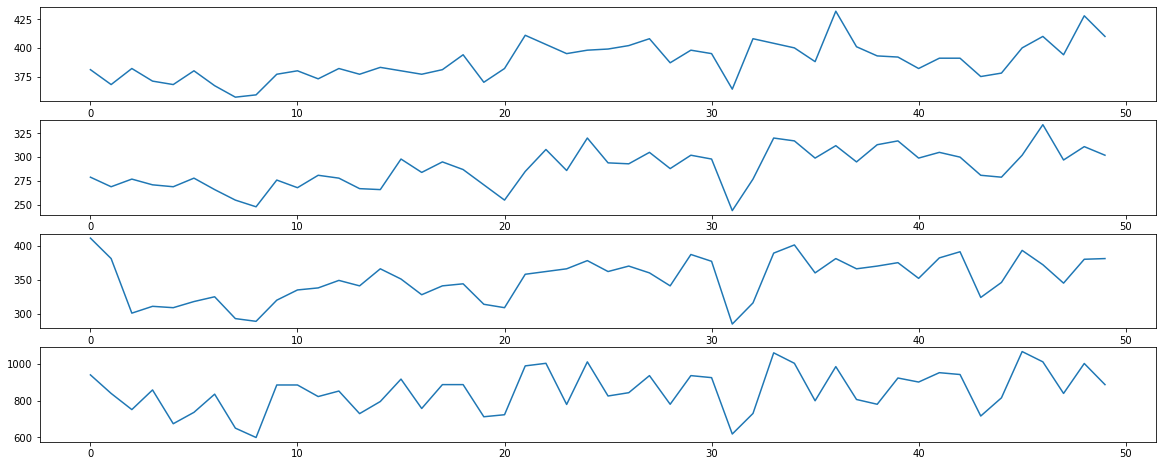

In [4]:
fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot(4, 1, 1)
ax.plot(data['Sandgate_Road_Abbotsford_Road_PM'])
ax = fig.add_subplot(4, 1, 2)
ax.plot(data['Coronation_Drive_PM'])
ax = fig.add_subplot(4, 1, 3)
ax.plot(data['Milton_Road_AM'])
ax = fig.add_subplot(4, 1, 4)
ax.plot(data['Fairfield_Road_Annerley_Road_AM'])

We'll use the PM columns only, then compute the interactions between each of the predictor variables. Finally, we'll standarise the data.

In [6]:
pm_data = data.iloc[:, 20:]
pm_data.head()

,Coronation_Drive_PM,Fairfield_Road_Annerley_Road_PM,Inner_City_Bypass_Eastbound_PM,Inner_City_Bypass_Westbound_PM,Ipswich_Road_Bradfield_Highway_PM,Kelvin_Grove_Road_PM,Kingsford_Smith_Drive_Breakfast_Creek_Road_PM,Logan_Road_PM,Lutwyche_Road_Bowen_Br_Road_PM,Milton_Road_PM,Moggill_Road_PM,Old_Cleveland_Road_PM,Oxley_Road_Coonan_Street_PM,Sandgate_Road_Abbotsford_Road_PM,Stanley_Street__inbound__PM,Vulture_Street__outbound__PM,Waterworks_Road_Musgrave_Road_PM,Wynnum_Road_PM
0,279,726,352,409,1242,451,534,776,456,492,519,633,923,381,589,721.0,882,1220
1,269,682,342,361,1185,422,525,782,427,407,445,588,816,368,530,600.0,844,1129
2,277,649,335,335,1088,423,524,753,442,285,487,555,909,382,592,650.0,804,1121
3,271,680,328,336,1082,433,528,758,417,285,475,562,873,371,534,650.0,790,1114
4,269,646,343,337,1012,414,520,739,394,280,403,538,848,368,558,580.0,764,1015


As per the last example, I'll manually create some interaction terms.

In [13]:
print(pm_data.iloc[:, 0:-1].columns)
print(pm_data.iloc[:, 0:].columns)

Index(['Coronation_Drive_PM', 'Fairfield_Road_Annerley_Road_PM',
       'Inner_City_Bypass_Eastbound_PM', 'Inner_City_Bypass_Westbound_PM',
       'Ipswich_Road_Bradfield_Highway_PM', 'Kelvin_Grove_Road_PM',
       'Kingsford_Smith_Drive_Breakfast_Creek_Road_PM', 'Logan_Road_PM',
       'Lutwyche_Road_Bowen_Br_Road_PM', 'Milton_Road_PM', 'Moggill_Road_PM',
       'Old_Cleveland_Road_PM', 'Oxley_Road_Coonan_Street_PM',
       'Sandgate_Road_Abbotsford_Road_PM', 'Stanley_Street__inbound__PM',
       'Vulture_Street__outbound__PM', 'Waterworks_Road_Musgrave_Road_PM'],
      dtype='object')
Index(['Coronation_Drive_PM', 'Fairfield_Road_Annerley_Road_PM',
       'Inner_City_Bypass_Eastbound_PM', 'Inner_City_Bypass_Westbound_PM',
       'Ipswich_Road_Bradfield_Highway_PM', 'Kelvin_Grove_Road_PM',
       'Kingsford_Smith_Drive_Breakfast_Creek_Road_PM', 'Logan_Road_PM',
       'Lutwyche_Road_Bowen_Br_Road_PM', 'Milton_Road_PM', 'Moggill_Road_PM',
       'Old_Cleveland_Road_PM', 'Oxley_Road_Coo

In [7]:
X = pm_data.iloc[:, 0:-1]
Y = pm_data.iloc[:, -1]
cols = X.columns
for i in range(len(cols)):
    for j in range(i+1,len(cols)):
        X[cols[i] +  '*' + cols[j]] = X[cols[i]]*X[cols[j]]

X.head()

/tmp/ipykernel_27392/2790746756.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[cols[i] +  '*' + cols[j]] = X[cols[i]]*X[cols[j]]
/tmp/ipykernel_27392/2790746756.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[cols[i] +  '*' + cols[j]] = X[cols[i]]*X[cols[j]]
/tmp/ipykernel_27392/2790746756.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get 

,Coronation_Drive_PM,Fairfield_Road_Annerley_Road_PM,Inner_City_Bypass_Eastbound_PM,Inner_City_Bypass_Westbound_PM,Ipswich_Road_Bradfield_Highway_PM,Kelvin_Grove_Road_PM,Kingsford_Smith_Drive_Breakfast_Creek_Road_PM,Logan_Road_PM,Lutwyche_Road_Bowen_Br_Road_PM,Milton_Road_PM,...,Oxley_Road_Coonan_Street_PM*Sandgate_Road_Abbotsford_Road_PM,Oxley_Road_Coonan_Street_PM*Stanley_Street__inbound__PM,Oxley_Road_Coonan_Street_PM*Vulture_Street__outbound__PM,Oxley_Road_Coonan_Street_PM*Waterworks_Road_Musgrave_Road_PM,Sandgate_Road_Abbotsford_Road_PM*Stanley_Street__inbound__PM,Sandgate_Road_Abbotsford_Road_PM*Vulture_Street__outbound__PM,Sandgate_Road_Abbotsford_Road_PM*Waterworks_Road_Musgrave_Road_PM,Stanley_Street__inbound__PM*Vulture_Street__outbound__PM,Stanley_Street__inbound__PM*Waterworks_Road_Musgrave_Road_PM,Vulture_Street__outbound__PM*Waterworks_Road_Musgrave_Road_PM
0,279,726,352,409,1242,451,534,776,456,492,...,351663,543647,665483.0,814086,224409,274701.0,336042,424669.0,519498,635922.0
1,269,682,342,361,1185,422,525,782,427,407,...,300288,432480,489600.0,688704,195040,220800.0,310592,318000.0,447320,506400.0
2,277,649,335,335,1088,423,524,753,442,285,...,347238,538128,590850.0,730836,226144,248300.0,307128,384800.0,475968,522600.0
3,271,680,328,336,1082,433,528,758,417,285,...,323883,466182,567450.0,689670,198114,241150.0,293090,347100.0,421860,513500.0
4,269,646,343,337,1012,414,520,739,394,280,...,312064,473184,491840.0,647872,205344,213440.0,281152,323640.0,426312,443120.0


In [14]:
X_mu = X.mean()
X_sigma = X.std()
X = (X - X_mu) / X_sigma
Y_mu = Y.mean()
Y_sigma = Y.std()
Y = (Y - Y_mu) / Y_sigma

### Adding a Constant Term, Or Not

There's usually a lot of confusion around constant terms, so we'll set it out here: **if you're using standardised data, you do not need to add a constant term**. 

The process of standardisation sets the constant offset that the constant term is capturing to 0. So if you to be pedantic, there is still a constant term, but it's set to 0. If you don't use standarised data, you should add a constant term.

Finally, we'll get our training, validation and testing splits.

In [15]:
train_samples = int(len(X)*0.6)
val_samples = int(len(X)*0.2)
X_train = X.iloc[:train_samples, :]
Y_train = Y.iloc[:train_samples]
X_val = X.iloc[train_samples:(train_samples + val_samples), :]
Y_val = Y.iloc[train_samples:(train_samples + val_samples)]
X_test = X.iloc[(train_samples + val_samples):, :]
Y_test = Y.iloc[(train_samples + val_samples):]
print(numpy.shape(X_train))
print(numpy.shape(X_val))
print(numpy.shape(X_test))

(30, 153)
(10, 153)
(10, 153)


I've printed the size of the arrays here for a reason, to make it really obvious that we have more columns (variables) than rows (samples). This is generally not a desireable situation for machine learning - and it does make some models harder to use than others.

# A Linear Model
Let's start with the linear model. Will this work? Remembering that we've set this up to have many more dimensions than we do samples.

In [16]:
model = sm.OLS(Y_train.to_numpy(), X_train.to_numpy())
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 27 Mar 2022   Prob (F-statistic):                nan
Time:                        08:59:33   Log-Likelihood:                 923.38
No. Observations:                  30   AIC:                            -1787.
Df Residuals:                       0   BIC:                            -1745.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4584        inf          0        n

/opt/conda/envs/cab420-env/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1751: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/opt/conda/envs/cab420-env/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1751: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/opt/conda/envs/cab420-env/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1673: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


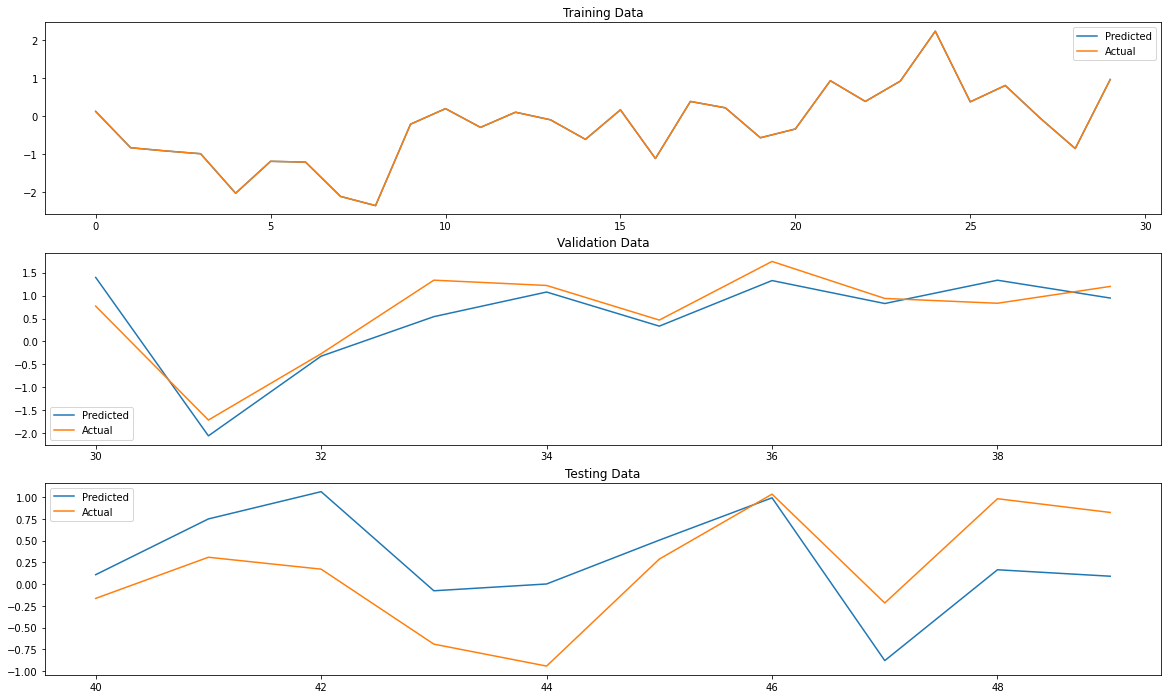

In [17]:
fig = plt.figure(figsize=[20, 12])
ax = fig.add_subplot(3, 1, 1)
ax.plot(trained_model.predict(X_train), label='Predicted')
ax.plot(Y_train, label='Actual')
ax.legend()
ax.set_title('Training Data')
ax = fig.add_subplot(3, 1, 2)
ax.plot(trained_model.predict(X_val), label='Predicted')
ax.plot(Y_val, label='Actual')
ax.legend()
ax.set_title('Validation Data')
ax = fig.add_subplot(3, 1, 3)
ax.plot(trained_model.predict(X_test), label='Predicted')
ax.plot(Y_test, label='Actual')
ax.legend()
ax.set_title('Testing Data');

So, has this gone wrong? Sort of.
We do have a warning about the input rank (how many variables we have) being higher than the number of observations - which we knew all about. And we do have no p-values or confidence intervals, or anything like that.
On the other side of the coin, our $R^2$ is 1 (i.e. perfect) and the plots don't look awful - though the test data plot is far from encouraging. So is this good or bad? And why has this even given us a model?

The OLS method in statsmodels (and actually similar models in many packages) will still try to find a way to fit things, it will just complain that it doesn't have enough data, and more than likely overfit (an $R^2$ of 1 is a little too good to be true). Does that mean we can't use this model? Maybe, we can perhaps use it with extreme caution. If our input data is very like the training data, it might even be ok. If it starts to deviate and the model has to generalise, we're probably in trouble. This is likely what we're seeing in the validation and testing data. Our data is all sequential (it's time series data, the training data is the first 60%, the validation is the next 20%, testing is the last 20%). What we are (perhaps) seeing is that in the validation data, the underlying system (our road network) hasn't changed much, and so can be well predicted. By the time we get to our test data, the accuracy seems to drop quite a bit. This could be due to changed traffic conditions (we do love digging holes) that impact the actual traffic network. This means that the traffic dynamics, and the underlying model, have changed, and becuase our model has overfit, it won't generalise.

We can also a linear regression model using sklearn, though it doesn't give us all the nice window dressing that statsmodels does (but as most of that is missing due to the lack of data, does it matter??).

In [18]:
out = LinearRegression(fit_intercept = False).fit(X = X_train.to_numpy(), y = Y_train.to_numpy())
print(out.coef_)
print(out.score(X_train.to_numpy(), Y_train.to_numpy()))

[ 0.45838393  0.89909541 -0.68078674  1.12952086  0.24983219 -0.06062696
  0.92297896  3.70418302  0.58748455  1.7001585  -1.07611369  1.90233703
  0.10932663  1.07729711  0.57432404  0.26417959 -0.44331611 -0.134146
 -0.36759625 -1.32108407  1.22736952  0.23984465 -0.48849669 -3.3851863
  0.77393448 -1.46089027  2.92209824 -0.3518498   2.15573537 -0.76928881
  1.14158662  0.44235189  0.79764731 -0.23559342 -0.60010178  0.7253493
 -0.16520984 -1.0485826  -0.48193906  0.06371157 -0.3330269  -0.51176577
 -0.45681177 -0.31323205 -0.26337428 -0.13778051  1.17296084  0.39857821
 -0.91873332  1.09615931  0.27479225 -0.81772497  0.6756291   0.78969494
  1.12151231 -0.12664898  0.51110648  0.36838728 -0.63796533  0.18562696
 -0.64269332  0.55800485 -0.96696588  0.36155605  0.41503178 -0.75407895
  0.11466658  1.098189   -0.089095    0.02242126  0.53851355  0.08051634
  0.43176504 -0.59246095  0.20975122  0.27705955 -0.98045224 -1.45953225
  0.4813185  -2.08495487  0.50285867 -0.58193718 -0.024

Text(0.5, 1.0, 'Testing Data')

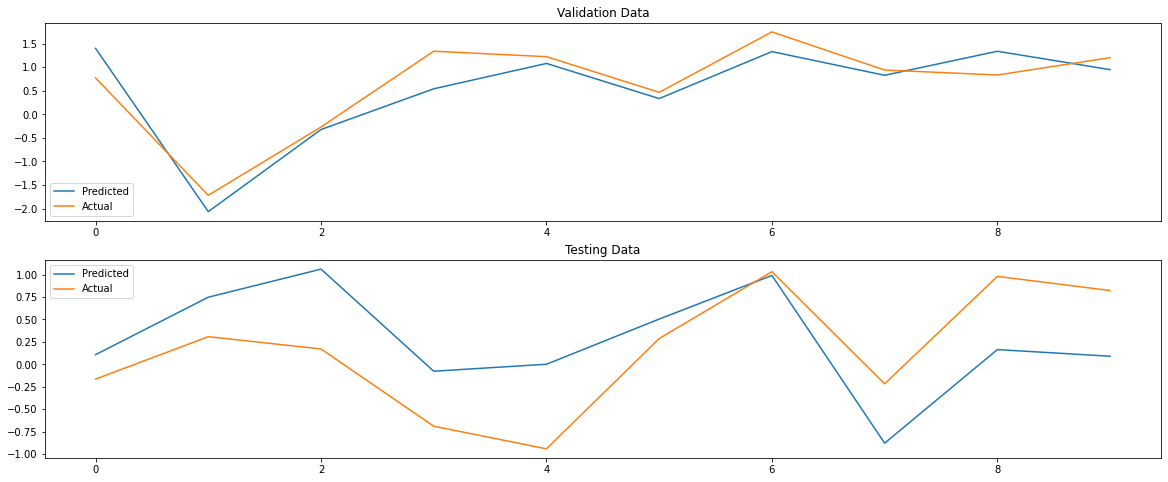

In [11]:
fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot(2, 1, 1)
ax.plot(out.predict(X_val.values), label='Predicted')
ax.plot(Y_val.to_numpy(), label='Actual')
ax.legend()
ax.set_title('Validation Data')
ax = fig.add_subplot(2, 1, 2)
ax.plot(out.predict(X_test.values), label='Predicted')
ax.plot(Y_test.to_numpy(), label='Actual')
ax.legend()
ax.set_title('Testing Data')

That said, we can see that we get the same results out of sklearn.

## Lasso Regression
Applying lasso though, actually works without complaining. Why? Two reasons:
* Becuase we have the L1 regularisation, this helps constrain the model and overcome the massivley limited data
* Because we are using a gradient descent solver, rather than trying to directly optimise
We're also going to continue using sklearn for our regularised regression, as statsmodels still seems to have incomplete functionality with regards to regularised regression models.

SkLearn is a bit more bare bones than statsmodels, but it gets the job done. One thing we need to do is provide our own range of $\lambda$, note that in SKLeran this is instead referred to as $\alpha$, as lambda is a keyword in python. Note also that the help warns against offering a $\lambda$ of 0 to Lasso (numerical instability), so we'll start at a small value near 0.

In [19]:
# get some alphas/lambdas to try
alphas = numpy.arange(0.0002, 1.0, 0.0002)
len(alphas)

4999

/opt/conda/envs/cab420-env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.406e-02, tolerance: 3.144e-03
  model = cd_fast.enet_coordinate_descent(
/opt/conda/envs/cab420-env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.677e-02, tolerance: 3.144e-03
  model = cd_fast.enet_coordinate_descent(
/opt/conda/envs/cab420-env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

Text(0.5, 1.0, 'Coefficients vs Alpha')

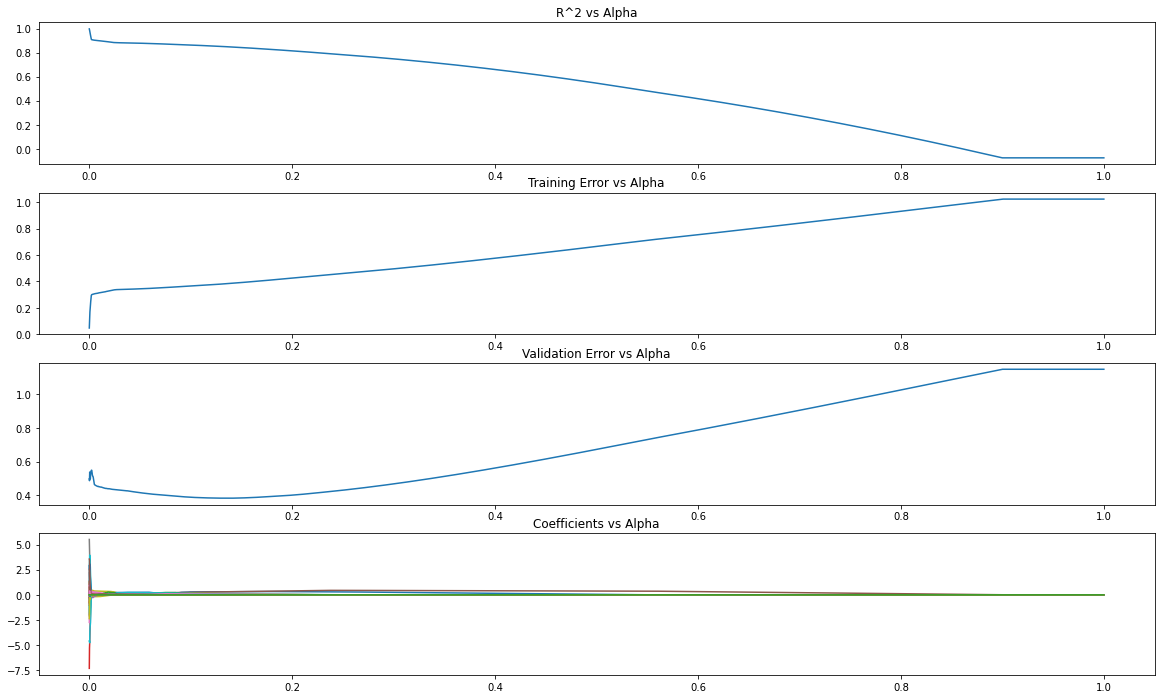

In [20]:
r_2 = []
coeff = []
train_acc = []
val_acc = []

# try them
# we'll also store
#  - the R^2 of the learned model
#  - the coeffiients
#  - the training and validation accuracies
for a in alphas:
    lasso_model = Lasso(fit_intercept=False, alpha=a, max_iter=100000).fit(X = X_train.to_numpy(), y = Y_train.to_numpy())
    r_2.append(lasso_model.score(X = X_train.to_numpy(), y = Y_train.to_numpy()))
    coeff.append(lasso_model.coef_)
    train_acc.append(numpy.sqrt(numpy.mean((lasso_model.predict(X_train.to_numpy()) - Y_train.to_numpy())**2)))
    val_acc.append(numpy.sqrt(numpy.mean((lasso_model.predict(X_val.to_numpy()) - Y_val.to_numpy())**2)))
    
# do some plots
fig = plt.figure(figsize=[20, 12])
ax = fig.add_subplot(4, 1, 1)
ax.plot(alphas, r_2)
ax.set_title('R^2 vs Alpha')
ax = fig.add_subplot(4, 1, 2)
ax.plot(alphas, train_acc)
ax.set_title('Training Error vs Alpha')
ax = fig.add_subplot(4, 1, 3)
ax.plot(alphas, val_acc)
ax.set_title('Validation Error vs Alpha')
ax = fig.add_subplot(4, 1, 4)
ax.plot(alphas, coeff)
ax.set_title('Coefficients vs Alpha')

What we see is
* $R^2$ goes down as $\lambda$ increases
* training error goes up
* validation error is actually best at a $\lambda$ of not quite 0
* most of our terms go to 0 pretty fast
Let's pull out the best model and check that out

In [24]:
X_val.shape

(10, 153)

0.13620000000000002


Text(0.5, 1.0, 'Testing Data')

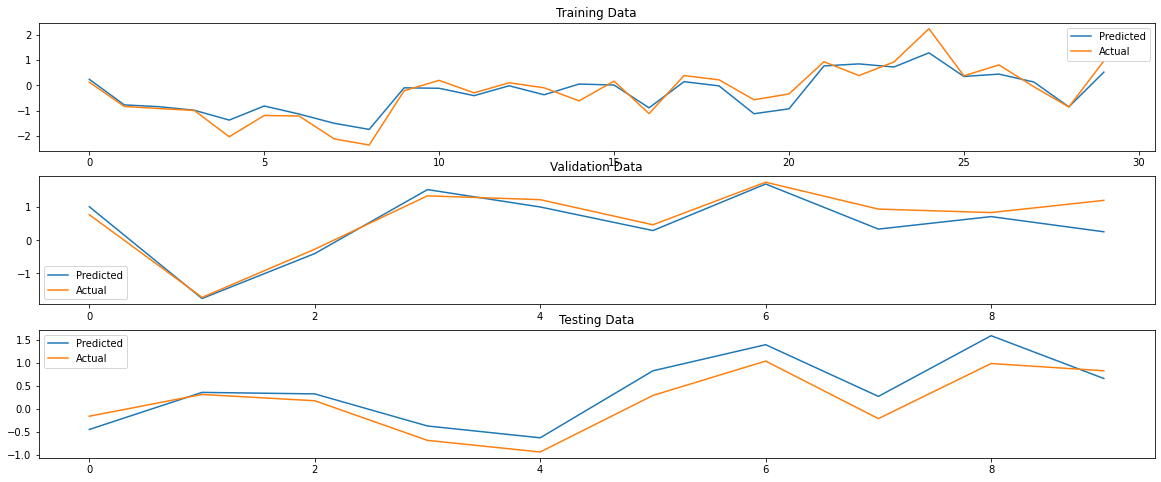

In [25]:
best_lasso_alpha = alphas[val_acc.index(min(val_acc))]
print(best_lasso_alpha)
lasso_model = Lasso(fit_intercept=False, alpha=best_lasso_alpha).fit(X = X_train.to_numpy(), y = Y_train.to_numpy())
fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot(3, 1, 1)
ax.plot(lasso_model.predict(X_train.values), label='Predicted')
ax.plot(Y_train.to_numpy(), label='Actual')
ax.legend()
ax.set_title('Training Data')
ax = fig.add_subplot(3, 1, 2)
ax.plot(lasso_model.predict(X_val.values), label='Predicted')
ax.plot(Y_val.to_numpy(), label='Actual')
ax.legend()
ax.set_title('Validation Data')
ax = fig.add_subplot(3, 1, 3)
ax.plot(lasso_model.predict(X_test.values), label='Predicted')
ax.plot(Y_test.to_numpy(), label='Actual')
ax.legend()
ax.set_title('Testing Data')

This looks much better, and is much more consistent across the training, validation and testing sets. Performance on the training data is no longer perfect, but in exchange for that we getter better results elsewhere.

## (Glenn) Ridge Regression
Now onto ridge regression. We'll do this in much the same way we did for Lasso, and again the help warns us against a $\lambda$ of 0, so again we'll start just past 0.

Text(0.5, 1.0, 'Coefficients vs Alpha')

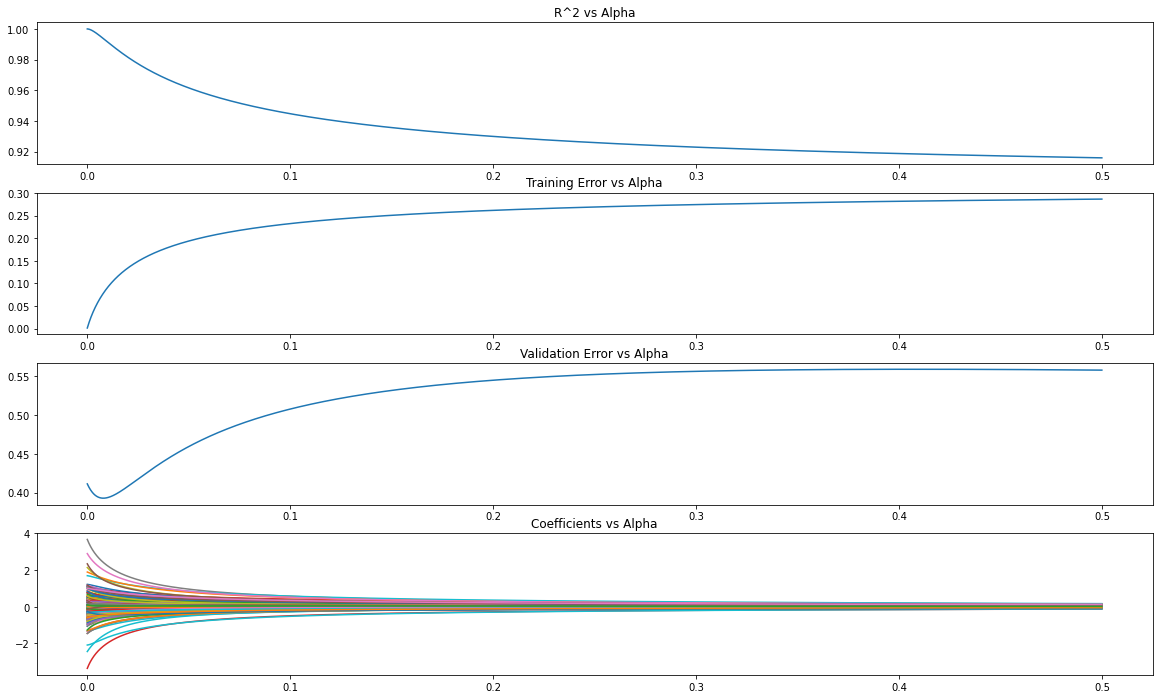

In [26]:
# using a bigger range now
alphas = numpy.arange(0.0001, 0.5, 0.0001)
r_2 = []
coeff = []
train_acc = []
val_acc = []

# compute ridge models, storing data as we did for Lasso
for a in alphas:
    glenn = Ridge(fit_intercept=False, alpha=a).fit(X = X_train.to_numpy(), y = Y_train.to_numpy())
    r_2.append(glenn.score(X = X_train.to_numpy(), y = Y_train.to_numpy()))
    coeff.append(glenn.coef_)
    train_acc.append(numpy.sqrt(numpy.mean((glenn.predict(X_train.to_numpy()) - Y_train.to_numpy())**2)))
    val_acc.append(numpy.sqrt(numpy.mean((glenn.predict(X_val.to_numpy()) - Y_val.to_numpy())**2)))

# plotting
fig = plt.figure(figsize=[20, 12])
ax = fig.add_subplot(4, 1, 1)
ax.plot(alphas, r_2)
ax.set_title('R^2 vs Alpha')
ax = fig.add_subplot(4, 1, 2)
ax.plot(alphas, train_acc)
ax.set_title('Training Error vs Alpha')
ax = fig.add_subplot(4, 1, 3)
ax.plot(alphas, val_acc)
ax.set_title('Validation Error vs Alpha')
ax = fig.add_subplot(4, 1, 4)
ax.plot(alphas, coeff)
ax.set_title('Coefficients vs Alpha')

These look similar to our LASSO counterparts, just smoother. We get our best performance all round for a fairly low $\lambda$, much like we say with LASSO. Note however that the value is $\lambda$ is very different between the two, and it's not reasonable to expect the value chosen for one method to be optimal for the other.

Now we'll pull out and plot the best ridge model.

0.008


Text(0.5, 1.0, 'Testing Data')

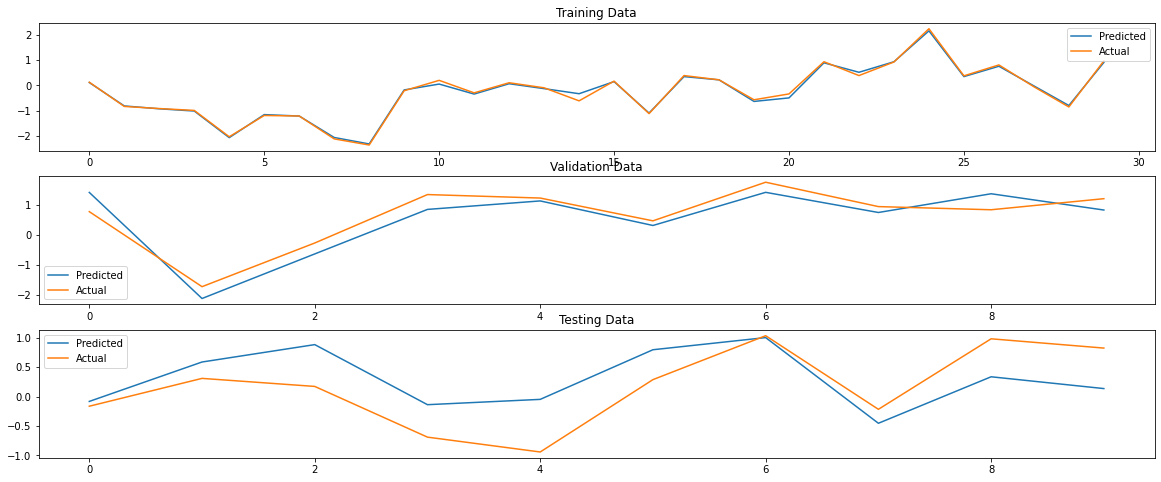

In [27]:
best_ridge_alpha = alphas[val_acc.index(min(val_acc))]
print(best_ridge_alpha)
glenn = Ridge(fit_intercept=False, alpha=best_ridge_alpha).fit(X = X_train.to_numpy(), y = Y_train.to_numpy())
fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot(3, 1, 1)
ax.plot(glenn.predict(X_train.values), label='Predicted')
ax.plot(Y_train.to_numpy(), label='Actual')
ax.legend()
ax.set_title('Training Data')
ax = fig.add_subplot(3, 1, 2)
ax.plot(glenn.predict(X_val.values), label='Predicted')
ax.plot(Y_val.to_numpy(), label='Actual')
ax.legend()
ax.set_title('Validation Data')
ax = fig.add_subplot(3, 1, 3)
ax.plot(glenn.predict(X_test.values), label='Predicted')
ax.plot(Y_test.to_numpy(), label='Actual')
ax.legend()
ax.set_title('Testing Data')

## Final Evaluation
Because, we can, let's have a look at the three models (linear, lasso and ridge) side by side.

Text(0.5, 1.0, 'Testing Data')

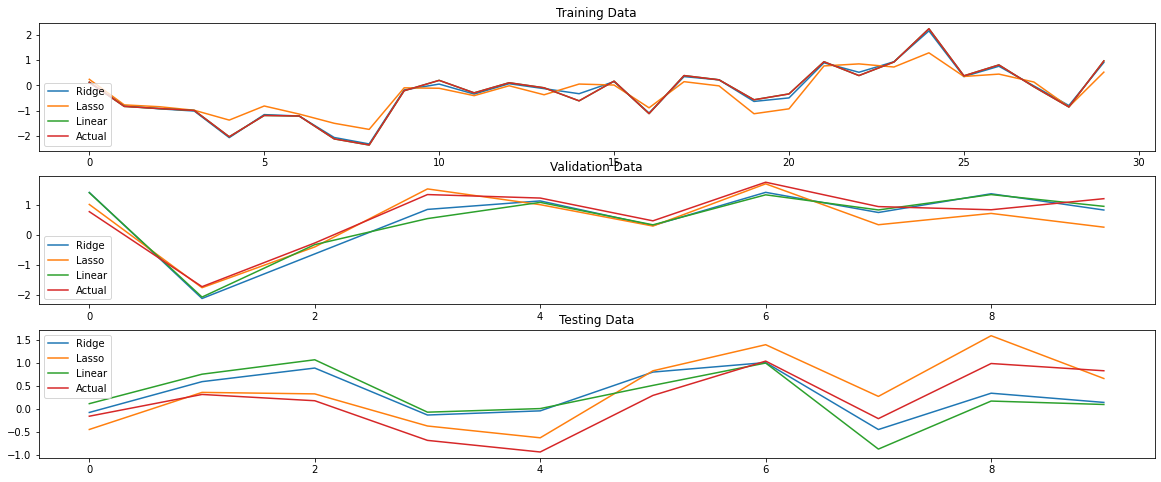

In [28]:
fig = plt.figure(figsize=[20, 8])

ax = fig.add_subplot(3, 1, 1)
ax.plot(glenn.predict(X_train.values), label='Ridge')
ax.plot(lasso_model.predict(X_train.values), label='Lasso')
ax.plot(out.predict(X_train.values), label='Linear')
ax.plot(Y_train.to_numpy(), label='Actual')
ax.legend()
ax.set_title('Training Data')

ax = fig.add_subplot(3, 1, 2)
ax.plot(glenn.predict(X_val.values), label='Ridge')
ax.plot(lasso_model.predict(X_val.values), label='Lasso')
ax.plot(out.predict(X_val.values), label='Linear')
ax.plot(Y_val.to_numpy(), label='Actual')
ax.legend()
ax.set_title('Validation Data')

ax = fig.add_subplot(3, 1, 3)
ax.plot(glenn.predict(X_test.values), label='Ridge')
ax.plot(lasso_model.predict(X_test.values), label='Lasso')
ax.plot(out.predict(X_test.values), label='Linear')
ax.plot(Y_test.to_numpy(), label='Actual')
ax.legend()
ax.set_title('Testing Data')

Our ridge and linear models are very similar. Lasso is clearly different, and clearly generalises better.

We can confirm that by looking at RMSE's on the test set. We see that the Ridge model is actually slightly better than the linear here, but the Lasso model is a long way ahead.

In [29]:
print('Linear Model, Test RMSE: ' + str(numpy.sqrt(numpy.mean((out.predict(X_test.to_numpy()) - Y_test.to_numpy())**2))))
print('Lasso Model, Test RMSE:  ' + str(numpy.sqrt(numpy.mean((lasso_model.predict(X_test.to_numpy()) - Y_test.to_numpy())**2))))
print('Ridge Model, Test RMSE:  ' + str(numpy.sqrt(numpy.mean((glenn.predict(X_test.to_numpy()) - Y_test.to_numpy())**2))))

Linear Model, Test RMSE: 0.6339736793723141
Lasso Model, Test RMSE:  0.36620606298967334
Ridge Model, Test RMSE:  0.5382769466138714


## Final Thoughts
In this example we've seen that:
* In an ideal world, we have more data points than we do samples; and in this our linear fitting with work and be happy
* In the real world (QUT pun intended), this is often not the case; but regularised method can (and do) work in these situations
* Note though that this doesn't mean that this is an excuse to use less data, in general you want to collect and use as much data as you can get
* Python has lots of of ways to do things. I'm not going to try and list all the different ways to do things, but statsmodels provides a nice API, albeit with some functionality missing, while SKLearn provides most methods under the sun, although often without a lot of bells and whistles. SKLearn does however have a very consistent API across many, many methods, which is nice. Feel free to look at what other packages are out there and try them out.

Things we have not done in this example:
* Properly evaluated our models. Where are the qqplots, $R^2$'s and all that? We've left them out in the interest of saving space. For any real application, you'd be doing this too to try and verify that the model is correct.